In [1]:
from datetime import datetime
from math import ceil
import requests
import time
import bs4
import sys

# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import cluster, covariance, manifold

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

In [3]:
matplotlib.matplotlib_fname()

'/Users/helloword/Develop/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'

In [4]:
import gc

In [5]:
#import akshare as ak

In [6]:
# ak.stock_zh_a_daily(symbol='sh601318') 中国平安 上证
# s = ak.stock_zh_a_daily(symbol='sz000651')# 格力 深证

In [7]:
# akshare "stock_zh_a_daily"  # 获取 A 股历史行情数据(日频)

## 爬虫模块，获取沪深300的所有股票列表

In [8]:
def obtain_parse_hushen_500():
    # 沪深300 wiki url
    hushen_300_wiki_url = 'https://zh.wikipedia.org/wiki/%E6%B2%AA%E6%B7%B1300'
    hushen_300_wiki_url.encode('utf-8')
    # Stores the current time, for the created_at record
    now = datetime.utcnow()

    # Use requests and BeautifulSoup to download the 
    # list of S&P500 companies and obtain the symbol table
    response = requests.get(
        hushen_300_wiki_url
    )
    soup = bs4.BeautifulSoup(response.text)
    
    symbolslist = soup.select('table')[0].select('tr')[1:]
    
    symbols = []
    sh_zh = '上海证券交易所'.encode('utf-8')
    sz_zh = '深圳证券交易所'.encode('utf-8')

    for i, symbol in enumerate(symbolslist):
        tds = symbol.select('td')
        tick = tds[0].text
        name_zh = tds[1].select('a')[0].text
        name_en = tds[2].text
        exchange_name = tds[3].text.encode('utf-8')
        exchange_name = 'sh' if exchange_name == sh_zh else 'sz'
        tick = exchange_name + tick
        symbols.append((
            tick
            ,name_zh
            ,name_en
            ,exchange_name
        ))
    df = pd.DataFrame(np.array(symbols))
    df.columns = ['ConstituentCode_WithExchange','Constituent_Name_zh','Constituent_Name_en','Exchange']
    return df

# obtain_parse_hushen_500()

In [9]:
# df = obtain_parse_hushen_500()
# df
# df.to_csv('./hushen300_symbols.csv',index=False)
# del df 
# gc.collect()

In [10]:
hushen300_symbols = pd.read_csv('./hushen300_symbols.csv')
hushen300_symbols

,ConstituentCode_WithExchange,Constituent_Name_zh,Constituent_Name_en,Exchange
0,sh600000,浦发银行,Shanghai Pudong Development Bank Co Ltd,sh
1,sh600008,首创股份,Beijing Capital Co Ltd,sh
2,sh600009,上海机场,Shanghai International Airport Co Ltd,sh
3,sh600010,包钢股份,Inner Mongolia Baotou Steel Union Co Ltd,sh
4,sh600011,华能国际,Huaneng Power International Inc,sh
...,...,...,...,...
295,sz300124,汇川技术,Shenzhen Inovance Technology Co Ltd,sz
296,sz300136,信维通信,Shenzhen Sunway Communication Co Ltd,sz
297,sz300144,宋城演艺,"SONGCHENG PERFORMANCE DEVELOPMENT CO., LTD.",sz
298,sz300251,光线传媒,Beijing Enlight Media Co Ltd,sz


## 使用akshare 爬取股票数据

In [11]:
def obtain_stocks():
    ticks = hushen300_symbols['ConstituentCode_WithExchange']
    names_zh = hushen300_symbols['Constituent_Name_zh']
    
    stocks = []
    for tick,name in zip(ticks,names):
        print('obtaining : ' , name)
        stocks.append(ak.stock_zh_a_daily(symbol = tick))
    return stocks
        
#stocks = obtain_stocks()

In [12]:
# quote_shapes = []
# for q in quotes:
#     quote_shapes.append(q.shape)
 
# quote_shapes = np.array(quote_shapes)

In [13]:
def read_stocks():
    stocks = []
    names_zh = hushen300_symbols['Constituent_Name_zh']
    names_en = hushen300_symbols['Constituent_Name_en']

    for name in names_zh:
        stocks.append(pd.read_csv('./hushen300/' + name + '.csv'))
    return stocks,names_zh,names_en

In [14]:
# display(names[0])
# display(stocks[0])
# display(names[-1:])
# display(stocks[-1])
# 去新浪财经看了下，无误

# 将时间戳分离开

In [15]:
def translate_datetime(X):
    X_ = X.copy()
    X_date = pd.DatetimeIndex(X['date'])
    X_['year'] = X_date.year
    X_['month'] = X_date.month
    X_['day'] = X_date.day
    return X_

## 转换成csv存储到本地

In [16]:
def stocks_to_csv(stocks):
    name_zh = hushen300_symbols['Constituent_Name_zh']
    # 将所有股票数据输出成csv
    for i,name_zh in enumerate(names):
        stocks[i].to_csv('./hushen300/' + name_zh + '.csv' , index=True) # 时间戳
    del stocks
    gc.collect()
#stocks_to_csv(stocks)

In [17]:
#stocks_to_csv(obtain_stocks())

## 总结

以后，爬下来的数据，生成的初始状态的csv，然后就存到本地，不要反反复复的爬，尤其这个数据，爬多了容易被锁ip，

非c端可以左一遍又一遍的试

可以做完完整的特征工程以后再存成新的csv 没有必要反复的去用爬虫爬下来的东西去做

In [18]:
stocks,names_zh,names_en = read_stocks()
stocks[0]

,date,open,high,low,close,volume
0,1999-11-10,29.50,29.80,27.00,27.75,174085100
1,1999-11-11,27.58,28.38,27.53,27.71,29403500
2,1999-11-12,27.86,28.30,27.77,28.05,15008000
3,1999-11-15,28.20,28.25,27.70,27.75,11921100
4,1999-11-16,27.88,27.97,26.48,26.55,23223100
...,...,...,...,...,...,...
4775,2020-01-17,12.22,12.29,12.16,12.23,17593111
4776,2020-01-20,12.26,12.27,12.19,12.25,23734609
4777,2020-01-21,12.20,12.25,12.04,12.08,31787474
4778,2020-01-22,11.70,11.84,11.65,11.77,78133556


[]

<Figure size 1440x864 with 0 Axes>

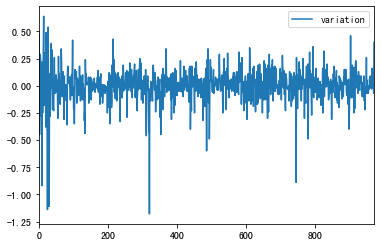

In [62]:
plt.figure(figsize=(20,12))
stocks[0].plot()
plt.plot()

## 转换时间戳

In [19]:
for i , s in enumerate(stocks):
    #s.reset_index(inplace = True)
    s = translate_datetime(s)
    #s.drop(columns='date',inplace=True)
    stocks[i] = s

In [20]:
stocks[0]

,date,open,high,low,close,volume,year,month,day
0,1999-11-10,29.50,29.80,27.00,27.75,174085100,1999,11,10
1,1999-11-11,27.58,28.38,27.53,27.71,29403500,1999,11,11
2,1999-11-12,27.86,28.30,27.77,28.05,15008000,1999,11,12
3,1999-11-15,28.20,28.25,27.70,27.75,11921100,1999,11,15
4,1999-11-16,27.88,27.97,26.48,26.55,23223100,1999,11,16
...,...,...,...,...,...,...,...,...,...
4775,2020-01-17,12.22,12.29,12.16,12.23,17593111,2020,1,17
4776,2020-01-20,12.26,12.27,12.19,12.25,23734609,2020,1,20
4777,2020-01-21,12.20,12.25,12.04,12.08,31787474,2020,1,21
4778,2020-01-22,11.70,11.84,11.65,11.77,78133556,2020,1,22


## 简单做一个分析

In [21]:
min_years = []
for s in stocks:
    min_years.append(s['year'].min())
min_years = np.array(min_years)

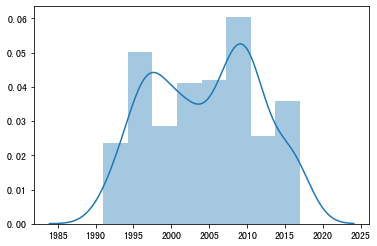

In [22]:
sns.distplot(min_years)

## 数据是不整齐的

In [23]:
for year in np.arange(2010,2019):
    print('less than : ', year, ' has ' , min_years[min_years >= year].shape[0])

less than :  2010  has  93
less than :  2011  has  60
less than :  2012  has  43
less than :  2013  has  37
less than :  2014  has  35
less than :  2015  has  32
less than :  2016  has  21
less than :  2017  has  8
less than :  2018  has  0


# 全部股票的聚类

首先数据是不整齐的，不但 各个公司上市的时间各有不同，而且还有闭市时间不同这尼玛

这里我们做两种聚类

- 将所有的股票按照16年最晚的上市时间，将一些无法进行正常聚类的股票排除走, 将缺失的时间段填0
- 将所有的股票都按照全量时间段来聚类，如果上市时间不同，就将这只股票不存在的时间给填充为0

## 从 2016-1-1 到至今 一直在市的公司的聚类

In [24]:
print('len stocks : ', len(stocks))

len stocks :  300


In [25]:
listing_date = []
for i , stock in enumerate(stocks):
    listing_date.append(stock['date'].min())
    stocks[i] = stock[stock['date'] > '2016-01-01'].reset_index(drop=True)

In [26]:
#indecies , uniques , cnts = np.unique(stock_shapes , return_counts=True,return_index=True)
#display(indecies)
#display(uniques)
#display(cnts)

### 1. 去掉多余的列

从上面看出

大量的日期不对齐，不太好处理

我先把数据中多余的部分去除掉，只留下时间戳和 新变量 = close - open

In [27]:
for i,stock in enumerate(stocks):
    # The daily variations of the quotes are what carry most information
    # 每日变化的报价承载着最多的信息
    variation = stock['open'] - stock['close']
    stock['variation'] = variation
    stock = stock[['date','variation']]
    stock.reset_index(inplace=True,drop=True)
    stocks[i] = stock

In [28]:
stocks[1]

,date,variation
0,2016-01-04,1.02
1,2016-01-05,-0.35
2,2016-01-06,-0.12
3,2016-01-07,0.85
4,2016-01-08,-0.07
...,...,...
976,2020-01-17,-0.01
977,2020-01-20,-0.04
978,2020-01-21,0.05
979,2020-01-22,-0.06


### 2. 将所有的股票variation都合并到一个表里

In [29]:
def datelist(beginDate, endDate):
    # beginDate, endDate是形如‘20160601’的字符串或datetime格式
    date_l=[datetime.strftime(x,'%Y-%m-%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
    return date_l

In [30]:
va_list = pd.DataFrame(datelist('2016-01-01','2020-01-01'))
va_list['variation'] = 0
va_list.columns = ['date','variation']
va_list

,date,variation
0,2016-01-01,0
1,2016-01-02,0
2,2016-01-03,0
3,2016-01-04,0
4,2016-01-05,0
...,...,...
1457,2019-12-28,0
1458,2019-12-29,0
1459,2019-12-30,0
1460,2019-12-31,0


In [31]:
for i,stock in enumerate(stocks):
    va_list = va_list.merge(stock[['date','variation']] , how='left',on='date',suffixes = ['', '_' + str(i)])
va_list.drop(columns=['variation'] , inplace=True)
va_list

,date,variation_0,variation_1,variation_2,variation_3,variation_4,variation_5,variation_6,variation_7,variation_8,...,variation_290,variation_291,variation_292,variation_293,variation_294,variation_295,variation_296,variation_297,variation_298,variation_299
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,0.48,1.02,1.26,0.36,0.48,0.57,0.45,0.51,0.37,...,6.95,4.75,4.15,2.67,3.09,3.88,2.18,2.09,2.74,1.22
4,2016-01-05,-0.45,-0.35,-1.24,-0.15,-0.22,-0.27,-0.17,-0.17,-0.23,...,-1.11,-1.29,-0.72,-2.25,-0.90,-0.26,-1.39,0.12,-1.12,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1458,2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1459,2019-12-30,-0.07,-0.02,-0.56,-0.01,0.01,-0.04,-0.05,-0.02,-0.08,...,-8.78,-0.84,-0.15,-0.09,0.44,-1.37,-1.11,0.25,-0.20,0.06
1460,2019-12-31,-0.05,-0.02,-0.88,0.00,-0.02,-0.02,-0.01,-0.04,-0.01,...,0.39,-0.07,0.00,-0.02,-1.17,0.02,0.33,0.00,-0.11,0.14


### 3. 删除掉所有列都为NaN的行

In [32]:
va_list.set_index(keys=['date'] , drop=True , inplace=True)
va_list.dropna(axis=0 , how='all' , inplace=True)
va_list

,variation_0,variation_1,variation_2,variation_3,variation_4,variation_5,variation_6,variation_7,variation_8,variation_9,...,variation_290,variation_291,variation_292,variation_293,variation_294,variation_295,variation_296,variation_297,variation_298,variation_299
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.48,1.02,1.26,0.36,0.48,0.57,0.45,0.51,0.37,1.38,...,6.95,4.75,4.15,2.67,3.09,3.88,2.18,2.09,2.74,1.22
2016-01-05,-0.45,-0.35,-1.24,-0.15,-0.22,-0.27,-0.17,-0.17,-0.23,-0.10,...,-1.11,-1.29,-0.72,-2.25,-0.90,-0.26,-1.39,0.12,-1.12,0.21
2016-01-06,-0.20,-0.12,-0.60,-0.25,-0.18,-0.07,-0.03,-0.09,-0.53,-0.39,...,-4.76,-0.79,-0.26,-0.45,-0.23,-0.09,0.20,-0.54,-0.07,-0.13
2016-01-07,0.29,0.85,1.20,0.25,0.49,0.57,0.43,0.42,0.47,1.08,...,3.98,2.88,3.22,2.62,2.29,2.83,2.32,1.91,2.15,0.93
2016-01-08,0.25,-0.07,0.55,-0.17,-0.02,0.15,0.18,-0.03,-0.32,0.19,...,-3.38,0.20,1.24,-0.04,1.80,1.00,0.66,-1.36,0.40,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.05,0.01,0.11,0.01,-0.01,0.03,0.02,0.03,0.04,-0.08,...,0.90,-0.04,0.02,0.03,-2.13,0.18,-0.81,-0.38,-0.05,-0.09
2019-12-26,-0.03,-0.02,-0.29,-0.01,-0.05,-0.04,-0.02,0.00,-0.04,-0.10,...,-3.85,-0.28,-0.04,-0.03,0.07,0.03,-0.21,-1.00,-0.03,0.13
2019-12-27,-0.07,0.01,0.33,-0.02,0.10,-0.04,-0.03,-0.02,-0.05,0.02,...,4.96,0.45,0.14,-0.03,1.19,-0.50,0.79,0.24,0.31,0.12


### 4. 分析缺失值

In [33]:
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        # written by MJ Bahmani
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [34]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return tt,(np.transpose(tt))
tt,tt2 = missing_data(va_list)


In [35]:
tt

,Total,Percent,Types
variation_0,18,1.846154,float64
variation_1,10,1.025641,float64
variation_2,0,0.000000,float64
variation_3,9,0.923077,float64
variation_4,0,0.000000,float64
...,...,...,...
variation_295,11,1.128205,float64
variation_296,0,0.000000,float64
variation_297,2,0.205128,float64
variation_298,34,3.487179,float64


In [36]:
tt2

,variation_0,variation_1,variation_2,variation_3,variation_4,variation_5,variation_6,variation_7,variation_8,variation_9,...,variation_290,variation_291,variation_292,variation_293,variation_294,variation_295,variation_296,variation_297,variation_298,variation_299
Total,18,10,0,9,0,0,0,3,92,77,...,1,5,14,20,0,11,0,2,34,99
Percent,1.84615,1.02564,0,0.923077,0,0,0,0.307692,9.4359,7.89744,...,0.102564,0.512821,1.4359,2.05128,0,1.12821,0,0.205128,3.48718,10.1538
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


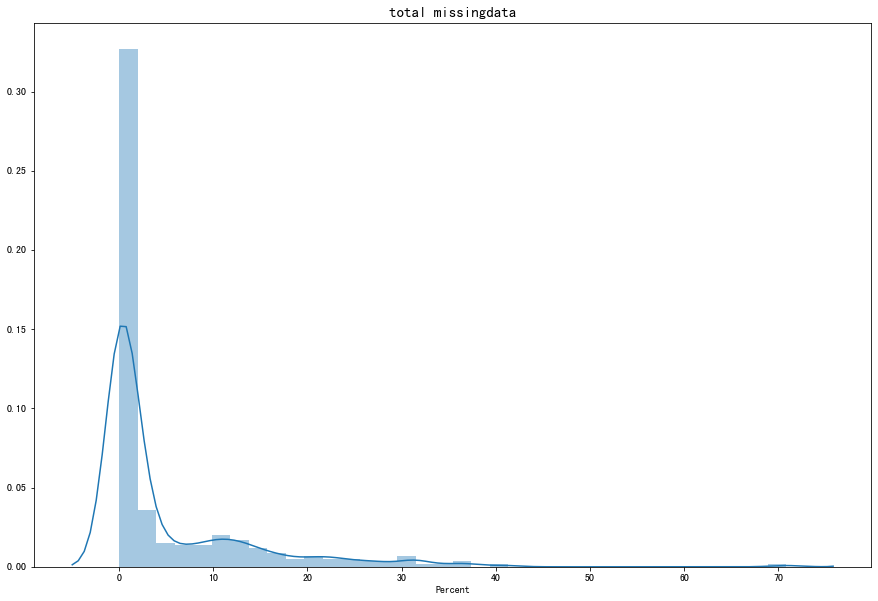

In [37]:
plt.figure(figsize=(15,10))
plt.title("total missingdata",fontsize=15)
sns.distplot(tt['Percent'])
plt.show()

### 5.将缺失值全部ffill

In [38]:
def fillInf(df):
    numcols = df.select_dtypes(include='number').columns
    cols = numcols[numcols != 'winPlacePerc']
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    for c in cols: 
        df[c].fillna(method='ffill')

In [39]:
def fillInf_with_val(df, val):
    numcols = df.select_dtypes(include='number').columns
    cols = numcols[numcols != 'winPlacePerc']
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    for c in cols: 
        df[c].fillna(val, inplace=True)

In [40]:
fillInf(va_list)
va_list

,variation_0,variation_1,variation_2,variation_3,variation_4,variation_5,variation_6,variation_7,variation_8,variation_9,...,variation_290,variation_291,variation_292,variation_293,variation_294,variation_295,variation_296,variation_297,variation_298,variation_299
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.48,1.02,1.26,0.36,0.48,0.57,0.45,0.51,0.37,1.38,...,6.95,4.75,4.15,2.67,3.09,3.88,2.18,2.09,2.74,1.22
2016-01-05,-0.45,-0.35,-1.24,-0.15,-0.22,-0.27,-0.17,-0.17,-0.23,-0.10,...,-1.11,-1.29,-0.72,-2.25,-0.90,-0.26,-1.39,0.12,-1.12,0.21
2016-01-06,-0.20,-0.12,-0.60,-0.25,-0.18,-0.07,-0.03,-0.09,-0.53,-0.39,...,-4.76,-0.79,-0.26,-0.45,-0.23,-0.09,0.20,-0.54,-0.07,-0.13
2016-01-07,0.29,0.85,1.20,0.25,0.49,0.57,0.43,0.42,0.47,1.08,...,3.98,2.88,3.22,2.62,2.29,2.83,2.32,1.91,2.15,0.93
2016-01-08,0.25,-0.07,0.55,-0.17,-0.02,0.15,0.18,-0.03,-0.32,0.19,...,-3.38,0.20,1.24,-0.04,1.80,1.00,0.66,-1.36,0.40,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.05,0.01,0.11,0.01,-0.01,0.03,0.02,0.03,0.04,-0.08,...,0.90,-0.04,0.02,0.03,-2.13,0.18,-0.81,-0.38,-0.05,-0.09
2019-12-26,-0.03,-0.02,-0.29,-0.01,-0.05,-0.04,-0.02,0.00,-0.04,-0.10,...,-3.85,-0.28,-0.04,-0.03,0.07,0.03,-0.21,-1.00,-0.03,0.13
2019-12-27,-0.07,0.01,0.33,-0.02,0.10,-0.04,-0.03,-0.02,-0.05,0.02,...,4.96,0.45,0.14,-0.03,1.19,-0.50,0.79,0.24,0.31,0.12


In [41]:
tt = check_missing_data(va_list)
tt

,variation_0,variation_1,variation_2,variation_3,variation_4,variation_5,variation_6,variation_7,variation_8,variation_9,...,variation_290,variation_291,variation_292,variation_293,variation_294,variation_295,variation_296,variation_297,variation_298,variation_299
Total,18,10,0,9,0,0,0,3,92,77,...,1,5,14,20,0,11,0,2,34,99
Percent,0.000184615,0.000102564,0,9.23077e-05,0,0,0,3.07692e-05,0.00094359,0.000789744,...,1.02564e-05,5.12821e-05,0.00014359,0.000205128,0,0.000112821,0,2.05128e-05,0.000348718,0.00101538
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [42]:
va_list

,variation_0,variation_1,variation_2,variation_3,variation_4,variation_5,variation_6,variation_7,variation_8,variation_9,...,variation_290,variation_291,variation_292,variation_293,variation_294,variation_295,variation_296,variation_297,variation_298,variation_299
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.48,1.02,1.26,0.36,0.48,0.57,0.45,0.51,0.37,1.38,...,6.95,4.75,4.15,2.67,3.09,3.88,2.18,2.09,2.74,1.22
2016-01-05,-0.45,-0.35,-1.24,-0.15,-0.22,-0.27,-0.17,-0.17,-0.23,-0.10,...,-1.11,-1.29,-0.72,-2.25,-0.90,-0.26,-1.39,0.12,-1.12,0.21
2016-01-06,-0.20,-0.12,-0.60,-0.25,-0.18,-0.07,-0.03,-0.09,-0.53,-0.39,...,-4.76,-0.79,-0.26,-0.45,-0.23,-0.09,0.20,-0.54,-0.07,-0.13
2016-01-07,0.29,0.85,1.20,0.25,0.49,0.57,0.43,0.42,0.47,1.08,...,3.98,2.88,3.22,2.62,2.29,2.83,2.32,1.91,2.15,0.93
2016-01-08,0.25,-0.07,0.55,-0.17,-0.02,0.15,0.18,-0.03,-0.32,0.19,...,-3.38,0.20,1.24,-0.04,1.80,1.00,0.66,-1.36,0.40,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.05,0.01,0.11,0.01,-0.01,0.03,0.02,0.03,0.04,-0.08,...,0.90,-0.04,0.02,0.03,-2.13,0.18,-0.81,-0.38,-0.05,-0.09
2019-12-26,-0.03,-0.02,-0.29,-0.01,-0.05,-0.04,-0.02,0.00,-0.04,-0.10,...,-3.85,-0.28,-0.04,-0.03,0.07,0.03,-0.21,-1.00,-0.03,0.13
2019-12-27,-0.07,0.01,0.33,-0.02,0.10,-0.04,-0.03,-0.02,-0.05,0.02,...,4.96,0.45,0.14,-0.03,1.19,-0.50,0.79,0.24,0.31,0.12


In [43]:
va_list.fillna(0,inplace=True)
check_missing_data(va_list)

False

In [44]:
va_list.reset_index(drop=True,inplace=True)
va_list

,variation_0,variation_1,variation_2,variation_3,variation_4,variation_5,variation_6,variation_7,variation_8,variation_9,...,variation_290,variation_291,variation_292,variation_293,variation_294,variation_295,variation_296,variation_297,variation_298,variation_299
0,0.48,1.02,1.26,0.36,0.48,0.57,0.45,0.51,0.37,1.38,...,6.95,4.75,4.15,2.67,3.09,3.88,2.18,2.09,2.74,1.22
1,-0.45,-0.35,-1.24,-0.15,-0.22,-0.27,-0.17,-0.17,-0.23,-0.10,...,-1.11,-1.29,-0.72,-2.25,-0.90,-0.26,-1.39,0.12,-1.12,0.21
2,-0.20,-0.12,-0.60,-0.25,-0.18,-0.07,-0.03,-0.09,-0.53,-0.39,...,-4.76,-0.79,-0.26,-0.45,-0.23,-0.09,0.20,-0.54,-0.07,-0.13
3,0.29,0.85,1.20,0.25,0.49,0.57,0.43,0.42,0.47,1.08,...,3.98,2.88,3.22,2.62,2.29,2.83,2.32,1.91,2.15,0.93
4,0.25,-0.07,0.55,-0.17,-0.02,0.15,0.18,-0.03,-0.32,0.19,...,-3.38,0.20,1.24,-0.04,1.80,1.00,0.66,-1.36,0.40,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,0.05,0.01,0.11,0.01,-0.01,0.03,0.02,0.03,0.04,-0.08,...,0.90,-0.04,0.02,0.03,-2.13,0.18,-0.81,-0.38,-0.05,-0.09
971,-0.03,-0.02,-0.29,-0.01,-0.05,-0.04,-0.02,0.00,-0.04,-0.10,...,-3.85,-0.28,-0.04,-0.03,0.07,0.03,-0.21,-1.00,-0.03,0.13
972,-0.07,0.01,0.33,-0.02,0.10,-0.04,-0.03,-0.02,-0.05,0.02,...,4.96,0.45,0.14,-0.03,1.19,-0.50,0.79,0.24,0.31,0.12
973,-0.07,-0.02,-0.56,-0.01,0.01,-0.04,-0.05,-0.02,-0.08,0.03,...,-8.78,-0.84,-0.15,-0.09,0.44,-1.37,-1.11,0.25,-0.20,0.06


In [45]:
variation = va_list.copy().T
del va_list
gc.collect()

5054

In [46]:
names = names_zh.copy()

In [47]:
variation

,0,1,2,3,4,5,6,7,8,9,...,965,966,967,968,969,970,971,972,973,974
variation_0,0.48,-0.45,-0.20,0.29,0.25,0.16,-0.28,0.18,-0.92,0.22,...,-0.04,-0.01,-0.01,0.26,-0.07,0.05,-0.03,-0.07,-0.07,-0.05
variation_1,1.02,-0.35,-0.12,0.85,-0.07,0.51,0.04,0.38,-0.39,0.43,...,0.00,-0.01,0.01,0.08,-0.01,0.01,-0.02,0.01,-0.02,-0.02
variation_2,1.26,-1.24,-0.60,1.20,0.55,0.89,0.54,0.63,-0.32,0.38,...,0.37,0.20,-0.81,0.65,0.32,0.11,-0.29,0.33,-0.56,-0.88
variation_3,0.36,-0.15,-0.25,0.25,-0.17,0.18,0.08,0.03,-0.17,0.12,...,-0.01,0.00,0.01,0.03,-0.02,0.01,-0.01,-0.02,-0.01,0.00
variation_4,0.48,-0.22,-0.18,0.49,-0.02,0.30,0.14,0.18,-0.18,0.25,...,-0.01,-0.01,0.00,0.10,-0.03,-0.01,-0.05,0.10,0.01,-0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
variation_295,3.88,-0.26,-0.09,2.83,1.00,1.51,-0.43,2.05,-3.23,1.52,...,0.00,-0.20,0.12,0.76,-0.24,0.18,0.03,-0.50,-1.37,0.02
variation_296,2.18,-1.39,0.20,2.32,0.66,1.76,-0.11,1.16,-2.66,0.53,...,0.10,0.75,-0.43,1.08,-0.77,-0.81,-0.21,0.79,-1.11,0.33
variation_297,2.09,0.12,-0.54,1.91,-1.36,0.13,-0.75,0.88,-2.46,-0.21,...,-0.34,0.35,-0.18,-0.34,-0.33,-0.38,-1.00,0.24,0.25,0.00
variation_298,2.74,-1.12,-0.07,2.15,0.40,1.43,-0.41,1.85,-1.98,0.53,...,-0.10,-0.41,0.04,0.51,-0.14,-0.05,-0.03,0.31,-0.20,-0.11


In [48]:
names

0      浦发银行
1      首创股份
2      上海机场
3      包钢股份
4      华能国际
       ... 
295    汇川技术
296    信维通信
297    宋城演艺
298    光线传媒
299    掌趣科技
Name: Constituent_Name_zh, Length: 300, dtype: object

In [49]:
gc.collect()

80

In [50]:
# #############################################################################
# Learn a graphical structure from the correlations
# 从相关关系中学习图形结构
edge_model = covariance.GraphicalLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
# 标准化时间序列:使用相关性而非协方差更有效地进行结构恢复
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

GraphicalLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
                 max_iter=100, mode='cd', n_jobs=None, n_refinements=4,
                 tol=0.0001, verbose=False)

In [51]:
# #############################################################################
# Cluster using affinity propagation
# 使用 affinity propagation 的聚类

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: 首创股份, 金隅集团
Cluster 2: 上海机场
Cluster 3: 华能国际
Cluster 4: 浦发银行, 华夏银行, 民生银行, 大秦铁路, 南京银行, 兴业银行, 北京银行, 交通银行, 光大银行, 中信银行, 平安银行, 宁波银行
Cluster 5: 宝钢股份, 海螺水泥, 中国神华, 鞍钢股份
Cluster 6: 中国石化, 上海石化, 中国石油
Cluster 7: 南方航空, 东方航空, 春秋航空, 中国国航
Cluster 8: 保利地产, 华夏幸福, 金地集团, 新城控股, 万科A, 华侨城A, 阳光城, 招商蛇口, 荣盛发展
Cluster 9: 中国联通
Cluster 10: 宇通客车
Cluster 11: 同仁堂, 白云山, 康美药业, 天士力, 上海医药, 东阿阿胶, 华东医药
Cluster 12: 包钢股份, 北方稀土, 厦门钨业
Cluster 13: 中直股份, 同方股份, 中国卫星, 中航电子, 中国动力, 中船防务, 鹏博士, 航发动力, 张江高科, 际华集团, 中国重工, 航发控制, 中航飞机, 海格通信
Cluster 14: 建发股份
Cluster 15: 兖州煤业, 陕西煤业, 中煤能源, 西山煤电
Cluster 16: 复星医药, 恒瑞医药, 信立泰
Cluster 17: 新湖中宝
Cluster 18: 圆通速递, 申通快递
Cluster 19: 航天信息
Cluster 20: 广汇汽车
Cluster 21: 万华化学
Cluster 22: 浙江龙盛
Cluster 23: 首开股份, 绿地控股, 金 融 街
Cluster 24: 国电南瑞
Cluster 25: 片仔癀, 云南白药, 爱尔眼科
Cluster 26: 中金黄金, 山东黄金, 紫金矿业
Cluster 27: 烽火通信, 中兴通讯
Cluster 28: 恒生电子, 用友网络, 同花顺
Cluster 29: 福耀玻璃
Cluster 30: 南京新百
Cluster 31: 川投能源, 国投电力
Cluster 32: 长江电力
Cluster 33: 中国电影
Cluster 34: 隆基股份
Cluster 35: 上港集团, 宁波港
Cluster 36: 三角轮胎
Cluster 37

In [52]:
len(labels)

300

In [53]:
len(names)

300

In [54]:
labels

array([ 3,  0,  1, 11,  2,  3,  3, 34,  4, 52, 52,  5,  6, 52, 55, 40, 12,
        7,  8, 52,  9, 36, 86, 10, 52, 12, 52, 52, 11,  6, 12, 13, 58, 52,
       52, 14, 15, 16, 58, 52, 17, 18, 15, 19, 20, 10,  7, 21, 58, 52, 12,
       86, 22,  7, 52, 23, 86, 24, 12, 86, 25, 26, 10, 60, 86, 10, 25, 11,
       27, 52,  4, 27, 22, 86, 52, 28, 86, 30, 29, 12,  5, 53, 72, 86, 52,
       52, 52, 52, 12, 52, 52, 52, 52, 86, 30, 53, 12, 12, 31, 44, 47, 47,
       52, 86, 32, 52,  3,  3, 33, 34,  6,  4, 52,  6, 36, 58,  7, 35,  3,
        3, 36, 52, 52, 37, 52, 14, 38, 39, 40, 41,  3, 43, 41, 44, 52, 36,
       40, 52, 58, 41, 10, 52, 42, 36, 41, 57, 36, 36, 52, 12, 52, 36, 52,
       36,  3,  5, 43, 43, 52, 44, 44, 45, 14, 25, 52, 43, 52, 40, 58, 46,
       52, 40, 12, 52,  0, 47,  3, 48, 49, 50, 51, 49,  3,  7, 86, 58, 26,
        7, 52, 55, 52, 53, 55, 22, 54, 52, 10, 55, 56, 24, 52, 86, 60, 52,
       57, 52, 58, 53,  7, 52, 62, 59, 52, 52, 12, 52, 12, 52, 52, 86, 52,
       86, 60, 82, 61,  4

In [55]:
names

0      浦发银行
1      首创股份
2      上海机场
3      包钢股份
4      华能国际
       ... 
295    汇川技术
296    信维通信
297    宋城演艺
298    光线传媒
299    掌趣科技
Name: Constituent_Name_zh, Length: 300, dtype: object

In [56]:
# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane
# 寻找可视化的低维嵌入:在二维平面上找到节点(股票)的最佳位置

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
# 我们使用一个密集的特征求解器来实现再现性(arpack是由我们无法控制的随机向量启动的)。
# 此外，我们使用大量的邻居来捕捉大规模的结构。
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

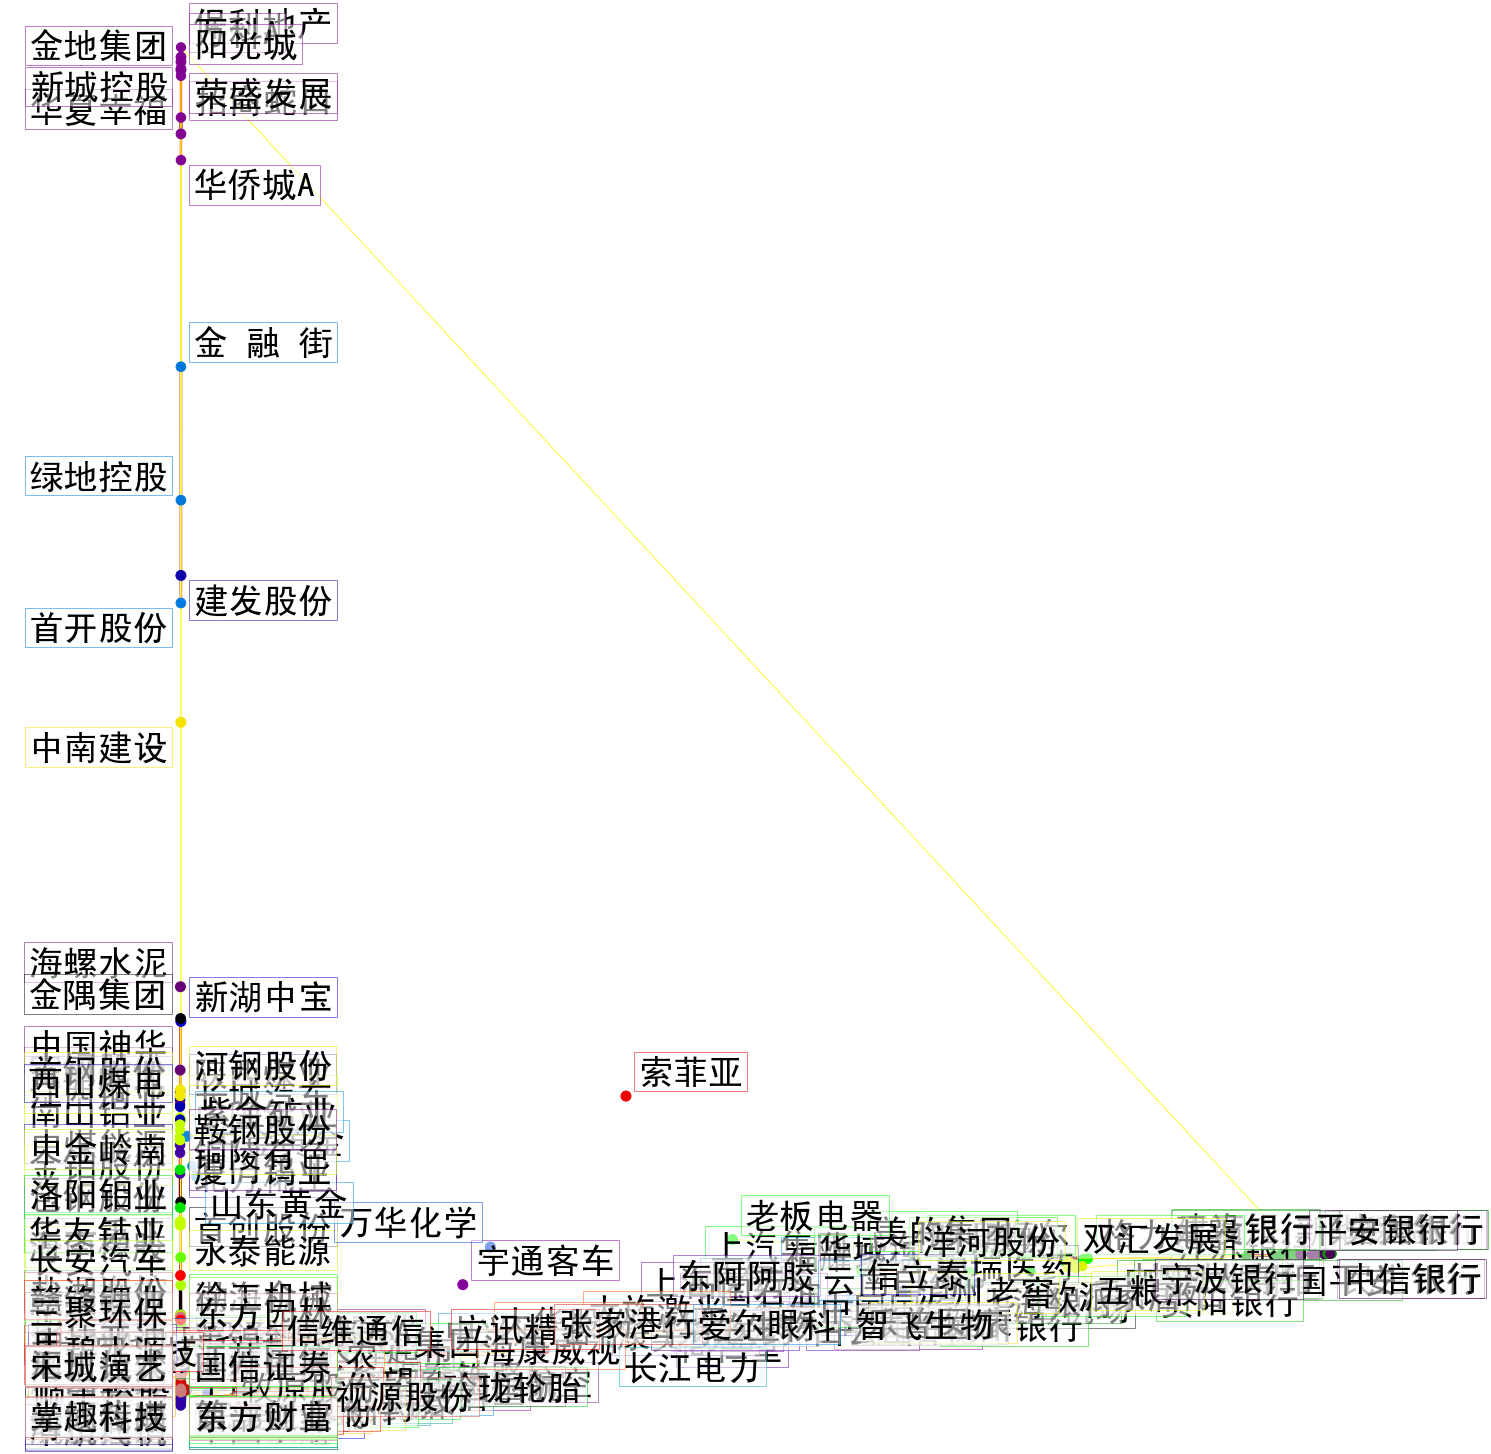

In [57]:
# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(20, 20))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=35,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.5))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

# 整合一下

In [58]:
def get_data(start_date='2014-1-1',end_date='2020-1-1'):
    
    stocks , names_zh , names_en = read_stocks()

    # 创建初始表 其中包含了所有的日期
    print('创建初始表 : ' , ' 开始日期 : ', start_date, ' 停止日期 : ' , end_date)
    va_list = pd.DataFrame(datelist(start_date,end_date))
    va_list['open'] = 0
    va_list['close'] = 0
    va_list.columns = ['date','open','close']

    # 将所有股票的报价变化合并到初始表中
    print('合并所有报价变化到初始表中......')
    for i , stock in enumerate(stocks):
        va_list = va_list.merge(
            stock[['date','open','close']] 
            , how='left'
            , on='date'
            , suffixes = ['', '_' + str(i)]
        )
        # ffill
        fillInf(va_list)
        # 计算所有报价变化
        va_list['va_' + str(i)] = va_list['close_' + str(i)] - va_list['open_' + str(i)]
        # 去掉无用列
        va_list.drop(columns=['close_' + str(i),'open_' + str(i)],inplace=True)

    print('整理数据......')
    # 去掉无用列
    va_list.drop(columns=['open','close'],inplace=True)
    # 删除所有全是无效值的行数据
    va_list.set_index(keys=['date'] , drop=True , inplace=True)
    va_list.dropna(axis=0 , how='all' , inplace=True)
    # 填充na
    fillInf_with_val(va_list,0)

    #def get_data(start_date,end_date):
    display('是否还有缺失数据 : ')
    display(check_missing_data(va_list))
    
    display('生成时序的报价变化矩阵......')
    variation = va_list.copy().T
    
    display('回收垃圾......')
    del va_list
    gc.collect()
    
    display(variation)
    return variation , names_zh

#variation,names = get_data()

In [59]:
def clustering_visualized(variation,names):
    # #############################################################################
    # Learn a graphical structure from the correlations
    # 从相关关系中学习图形结构
    print('从相关关系中学习图结构......')
    edge_model = covariance.GraphicalLassoCV()

    # standardize the time series: using correlations rather than covariance
    # is more efficient for structure recovery
    # 标准化时间序列:使用相关性而非协方差更有效地进行结构恢复
    X = variation.copy().T
    X /= X.std(axis=0)
    edge_model.fit(X)
    
    # #############################################################################
    # Cluster using affinity propagation
    # 使用 affinity propagation 的聚类
    print('聚类......')
    _, labels = cluster.affinity_propagation(edge_model.covariance_)
    n_labels = labels.max()

    for i in range(n_labels + 1):
        print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))
        
    # #############################################################################
    # Find a low-dimension embedding for visualization: find the best position of
    # the nodes (the stocks) on a 2D plane
    # 寻找可视化的低维嵌入:在二维平面上找到节点(股票)的最佳位置

    # We use a dense eigen_solver to achieve reproducibility (arpack is
    # initiated with random vectors that we don't control). In addition, we
    # use a large number of neighbors to capture the large-scale structure.
    # 我们使用一个密集的特征求解器来实现再现性(arpack是由我们无法控制的随机向量启动的)。
    # 此外，我们使用大量的邻居来捕捉大规模的结构。
    print('寻找可视化的低维嵌入:在二维平面上找到节点(股票)的最佳位置......')
    node_position_model = manifold.LocallyLinearEmbedding(
        n_components=2, eigen_solver='dense', n_neighbors=6)

    embedding = node_position_model.fit_transform(X.T).T
    
    print('可视化......')
    # #############################################################################
    # Visualization
    plt.figure(1, facecolor='w', figsize=(20, 20))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')

    # Display a graph of the partial correlations
    partial_correlations = edge_model.precision_.copy()
    d = 1 / np.sqrt(np.diag(partial_correlations))
    partial_correlations *= d
    partial_correlations *= d[:, np.newaxis]
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

    # Plot the nodes using the coordinates of our embedding
    plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
                cmap=plt.cm.nipy_spectral)

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    # a sequence of (*line0*, *line1*, *line2*), where::
    #            linen = (x0, y0), (x1, y1), ... (xm, ym)
    segments = [[embedding[:, start], embedding[:, stop]]
                for start, stop in zip(start_idx, end_idx)]
    values = np.abs(partial_correlations[non_zero])
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.hot_r,
                        norm=plt.Normalize(0, .7 * values.max()))
    lc.set_array(values)
    lc.set_linewidths(15 * values)
    ax.add_collection(lc)

    # Add a label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    for index, (name, label, (x, y)) in enumerate(
            zip(names, labels, embedding.T)):

        dx = x - embedding[0]
        dx[index] = 1
        dy = y - embedding[1]
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            horizontalalignment = 'left'
            x = x + .002
        else:
            horizontalalignment = 'right'
            x = x - .002
        if this_dy > 0:
            verticalalignment = 'bottom'
            y = y + .002
        else:
            verticalalignment = 'top'
            y = y - .002
        plt.text(x, y, name, size=35,
                 horizontalalignment=horizontalalignment,
                 verticalalignment=verticalalignment,
                 bbox=dict(facecolor='w',
                           edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                           alpha=.5))

    plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
             embedding[0].max() + .10 * embedding[0].ptp(),)
    plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
             embedding[1].max() + .03 * embedding[1].ptp())

    plt.show()

创建初始表 :   开始日期 :  2016-1-1  停止日期 :  2020-1-1
合并所有报价变化到初始表中......
整理数据......


'是否还有缺失数据 : '

False

'生成时序的报价变化矩阵......'

'回收垃圾......'

date,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31
va_0,-0.48,0.45,0.20,-0.29,-0.25,-0.16,0.28,-0.18,0.92,-0.22,...,0.04,0.01,0.01,-0.26,0.07,-0.05,0.03,0.07,0.07,0.05
va_1,-1.02,0.35,0.12,-0.85,0.07,-0.51,-0.04,-0.38,0.39,-0.43,...,0.00,0.01,-0.01,-0.08,0.01,-0.01,0.02,-0.01,0.02,0.02
va_2,-1.26,1.24,0.60,-1.20,-0.55,-0.89,-0.54,-0.63,0.32,-0.38,...,-0.37,-0.20,0.81,-0.65,-0.32,-0.11,0.29,-0.33,0.56,0.88
va_3,-0.36,0.15,0.25,-0.25,0.17,-0.18,-0.08,-0.03,0.17,-0.12,...,0.01,0.00,-0.01,-0.03,0.02,-0.01,0.01,0.02,0.01,0.00
va_4,-0.48,0.22,0.18,-0.49,0.02,-0.30,-0.14,-0.18,0.18,-0.25,...,0.01,0.01,0.00,-0.10,0.03,0.01,0.05,-0.10,-0.01,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
va_295,-3.88,0.26,0.09,-2.83,-1.00,-1.51,0.43,-2.05,3.23,-1.52,...,0.00,0.20,-0.12,-0.76,0.24,-0.18,-0.03,0.50,1.37,-0.02
va_296,-2.18,1.39,-0.20,-2.32,-0.66,-1.76,0.11,-1.16,2.66,-0.53,...,-0.10,-0.75,0.43,-1.08,0.77,0.81,0.21,-0.79,1.11,-0.33
va_297,-2.09,-0.12,0.54,-1.91,1.36,-0.13,0.75,-0.88,2.46,0.21,...,0.34,-0.35,0.18,0.34,0.33,0.38,1.00,-0.24,-0.25,0.00
va_298,-2.74,1.12,0.07,-2.15,-0.40,-1.43,0.41,-1.85,1.98,-0.53,...,0.10,0.41,-0.04,-0.51,0.14,0.05,0.03,-0.31,0.20,0.11


从相关关系中学习图结构......
聚类......
Cluster 1: 首创股份, 金隅集团
Cluster 2: 上海机场
Cluster 3: 华能国际
Cluster 4: 浦发银行, 华夏银行, 民生银行, 大秦铁路, 南京银行, 兴业银行, 北京银行, 交通银行, 光大银行, 中信银行, 平安银行, 宁波银行
Cluster 5: 宝钢股份, 海螺水泥, 中国神华, 鞍钢股份
Cluster 6: 中国石化, 上海石化, 中国石油
Cluster 7: 南方航空, 东方航空, 春秋航空, 中国国航
Cluster 8: 保利地产, 华夏幸福, 金地集团, 新城控股, 万科A, 华侨城A, 阳光城, 招商蛇口, 荣盛发展
Cluster 9: 中国联通
Cluster 10: 宇通客车
Cluster 11: 同仁堂, 白云山, 康美药业, 天士力, 上海医药, 东阿阿胶, 华东医药
Cluster 12: 包钢股份, 北方稀土, 厦门钨业
Cluster 13: 中直股份, 同方股份, 中国卫星, 中航电子, 中国动力, 中船防务, 鹏博士, 航发动力, 张江高科, 际华集团, 中国重工, 航发控制, 中航飞机, 海格通信
Cluster 14: 建发股份
Cluster 15: 兖州煤业, 陕西煤业, 中煤能源, 西山煤电
Cluster 16: 复星医药, 恒瑞医药, 信立泰
Cluster 17: 新湖中宝
Cluster 18: 圆通速递, 申通快递
Cluster 19: 航天信息
Cluster 20: 广汇汽车
Cluster 21: 万华化学
Cluster 22: 浙江龙盛
Cluster 23: 首开股份, 绿地控股, 金 融 街
Cluster 24: 国电南瑞
Cluster 25: 片仔癀, 云南白药, 爱尔眼科
Cluster 26: 中金黄金, 山东黄金, 紫金矿业
Cluster 27: 烽火通信, 中兴通讯
Cluster 28: 恒生电子, 用友网络, 同花顺
Cluster 29: 福耀玻璃
Cluster 30: 南京新百
Cluster 31: 川投能源, 国投电力
Cluster 32: 长江电力
Cluster 33: 中国电影
Cluster 34: 隆基股份
Cluster 35: 上港集团, 宁波港


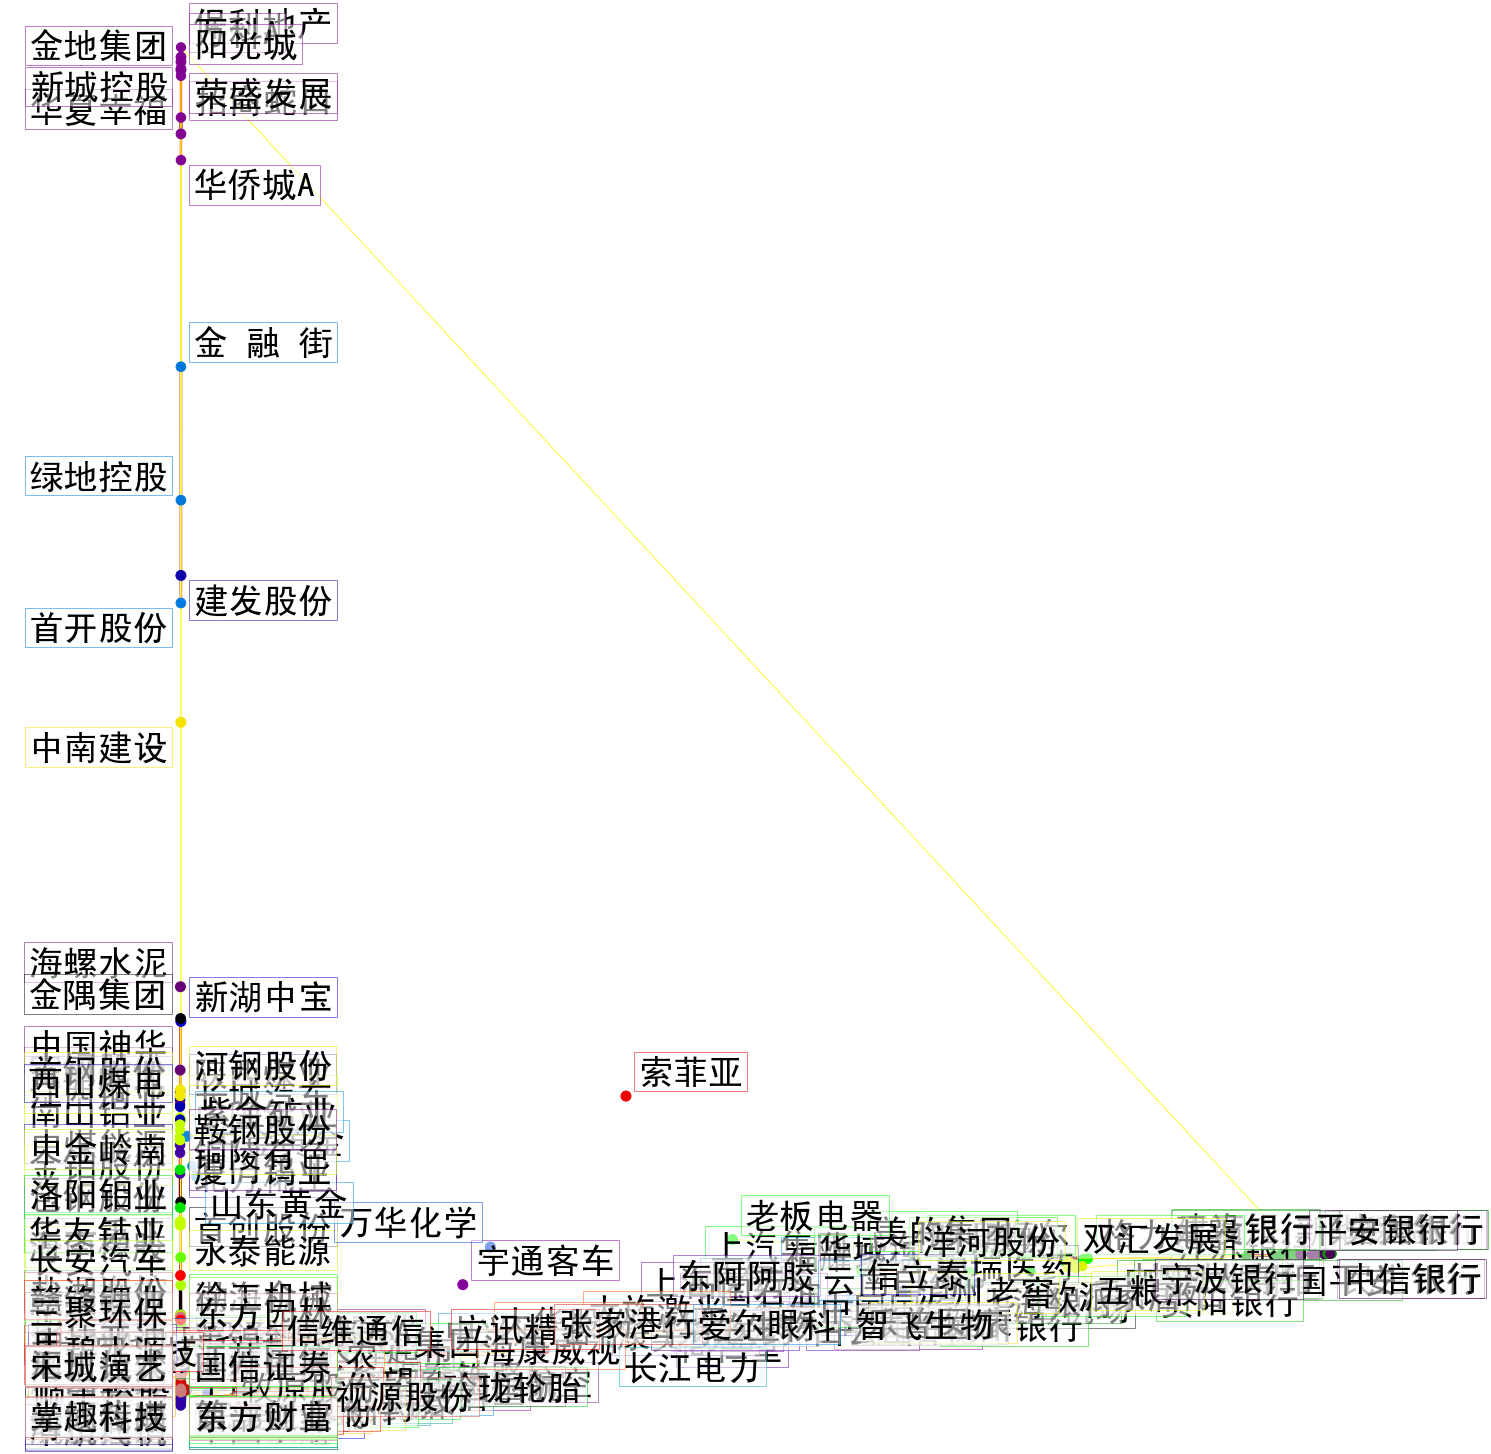

In [60]:
v,a = get_data('2016-1-1','2020-1-1')
clustering_visualized(v,a)

创建初始表 :   开始日期 :  2014-1-1  停止日期 :  2020-1-1
合并所有报价变化到初始表中......
整理数据......


'是否还有缺失数据 : '

False

'生成时序的报价变化矩阵......'

'回收垃圾......'

date,2014-01-02,2014-01-03,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-13,2014-01-14,2014-01-15,...,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31
va_0,-0.11,-0.14,-0.12,-0.03,0.06,0.09,0.13,-0.05,0.00,-0.16,...,0.04,0.01,0.01,-0.26,0.07,-0.05,0.03,0.07,0.07,0.05
va_1,-0.03,-0.07,-0.27,0.05,-0.05,-0.08,-0.27,-0.12,0.20,0.06,...,0.00,0.01,-0.01,-0.08,0.01,-0.01,0.02,-0.01,0.02,0.02
va_2,0.19,-0.12,-0.54,0.08,0.20,0.09,-0.02,-0.12,0.21,-0.08,...,-0.37,-0.20,0.81,-0.65,-0.32,-0.11,0.29,-0.33,0.56,0.88
va_3,0.00,0.00,-0.45,-0.10,-0.11,-0.09,-0.13,0.03,0.05,-0.07,...,0.01,0.00,-0.01,-0.03,0.02,-0.01,0.01,0.02,0.01,0.00
va_4,0.02,-0.04,-0.20,0.00,0.01,0.01,0.12,0.02,0.02,-0.12,...,0.01,0.01,0.00,-0.10,0.03,0.01,0.05,-0.10,-0.01,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
va_295,0.23,-0.79,-2.57,1.12,2.07,-1.43,1.40,0.53,1.00,0.29,...,0.00,0.20,-0.12,-0.76,0.24,-0.18,-0.03,0.50,1.37,-0.02
va_296,0.97,0.12,0.46,-0.17,0.01,1.19,-0.50,-0.06,0.35,-0.39,...,-0.10,-0.75,0.43,-1.08,0.77,0.81,0.21,-0.79,1.11,-0.33
va_297,0.18,0.47,-0.56,0.59,0.55,-0.41,0.17,-0.18,0.23,0.39,...,0.34,-0.35,0.18,0.34,0.33,0.38,1.00,-0.24,-0.25,0.00
va_298,0.97,1.58,-1.79,0.88,2.55,-1.01,0.63,1.70,-0.51,0.65,...,0.10,0.41,-0.04,-0.51,0.14,0.05,0.03,-0.31,0.20,0.11


从相关关系中学习图结构......
聚类......
Cluster 1: 上海机场
Cluster 2: 浦发银行, 华夏银行, 民生银行, 南京银行, 兴业银行, 北京银行, 交通银行, 光大银行, 中信银行, 平安银行, 宁波银行
Cluster 3: 上港集团, 宁波港
Cluster 4: 中国石化, 中国石油
Cluster 5: 南方航空, 东方航空, 海航控股, 春秋航空, 中国国航
Cluster 6: 保利地产, 华夏幸福, 首开股份, 金地集团, 新城控股, 万科A, 华侨城A, 金 融 街, 招商蛇口, 荣盛发展
Cluster 7: 宇通客车
Cluster 8: ST保千里
Cluster 9: 同仁堂, 白云山, 片仔癀, 天士力, 上海医药, 东阿阿胶, 云南白药
Cluster 10: 特变电工, 国电南瑞, 金螳螂, 金风科技
Cluster 11: 中直股份, 中国卫星, 中航电子, 中船防务, 鹏博士, 航发动力, 际华集团, 中国核电, 中国重工, 天茂集团, 航发控制, 中航飞机, 贵州百灵, 海格通信
Cluster 12: 建发股份
Cluster 13: 兖州煤业, 中国神华, 陕西煤业, 中煤能源, 西山煤电
Cluster 14: 复星医药, 恒瑞医药, 信立泰
Cluster 15: 圆通速递
Cluster 16: 广汇汽车
Cluster 17: 万华化学
Cluster 18: 浙江龙盛
Cluster 19: 中国动力
Cluster 20: 信威集团
Cluster 21: 中金黄金, 山东黄金, 紫金矿业
Cluster 22: 烽火通信, 中天科技, 中兴通讯, 大族激光, 信维通信
Cluster 23: 康美药业
Cluster 24: 航天信息, 用友网络, 东华软件, 石基信息, 科大讯飞, 掌趣科技
Cluster 25: 城投控股
Cluster 26: 南京新百
Cluster 27: 海油工程, 上海石化, 石化油服
Cluster 28: 上汽集团, 福耀玻璃, 华域汽车
Cluster 29: 同方股份, 上海建工, 小商品城, 绿地控股, 物产中大, 安信信托, 隧道股份, 江苏有线, 海南橡胶, 中信重工, 紫光股份
Cluster 30: 东方明珠, 陆家嘴, 中航资本,

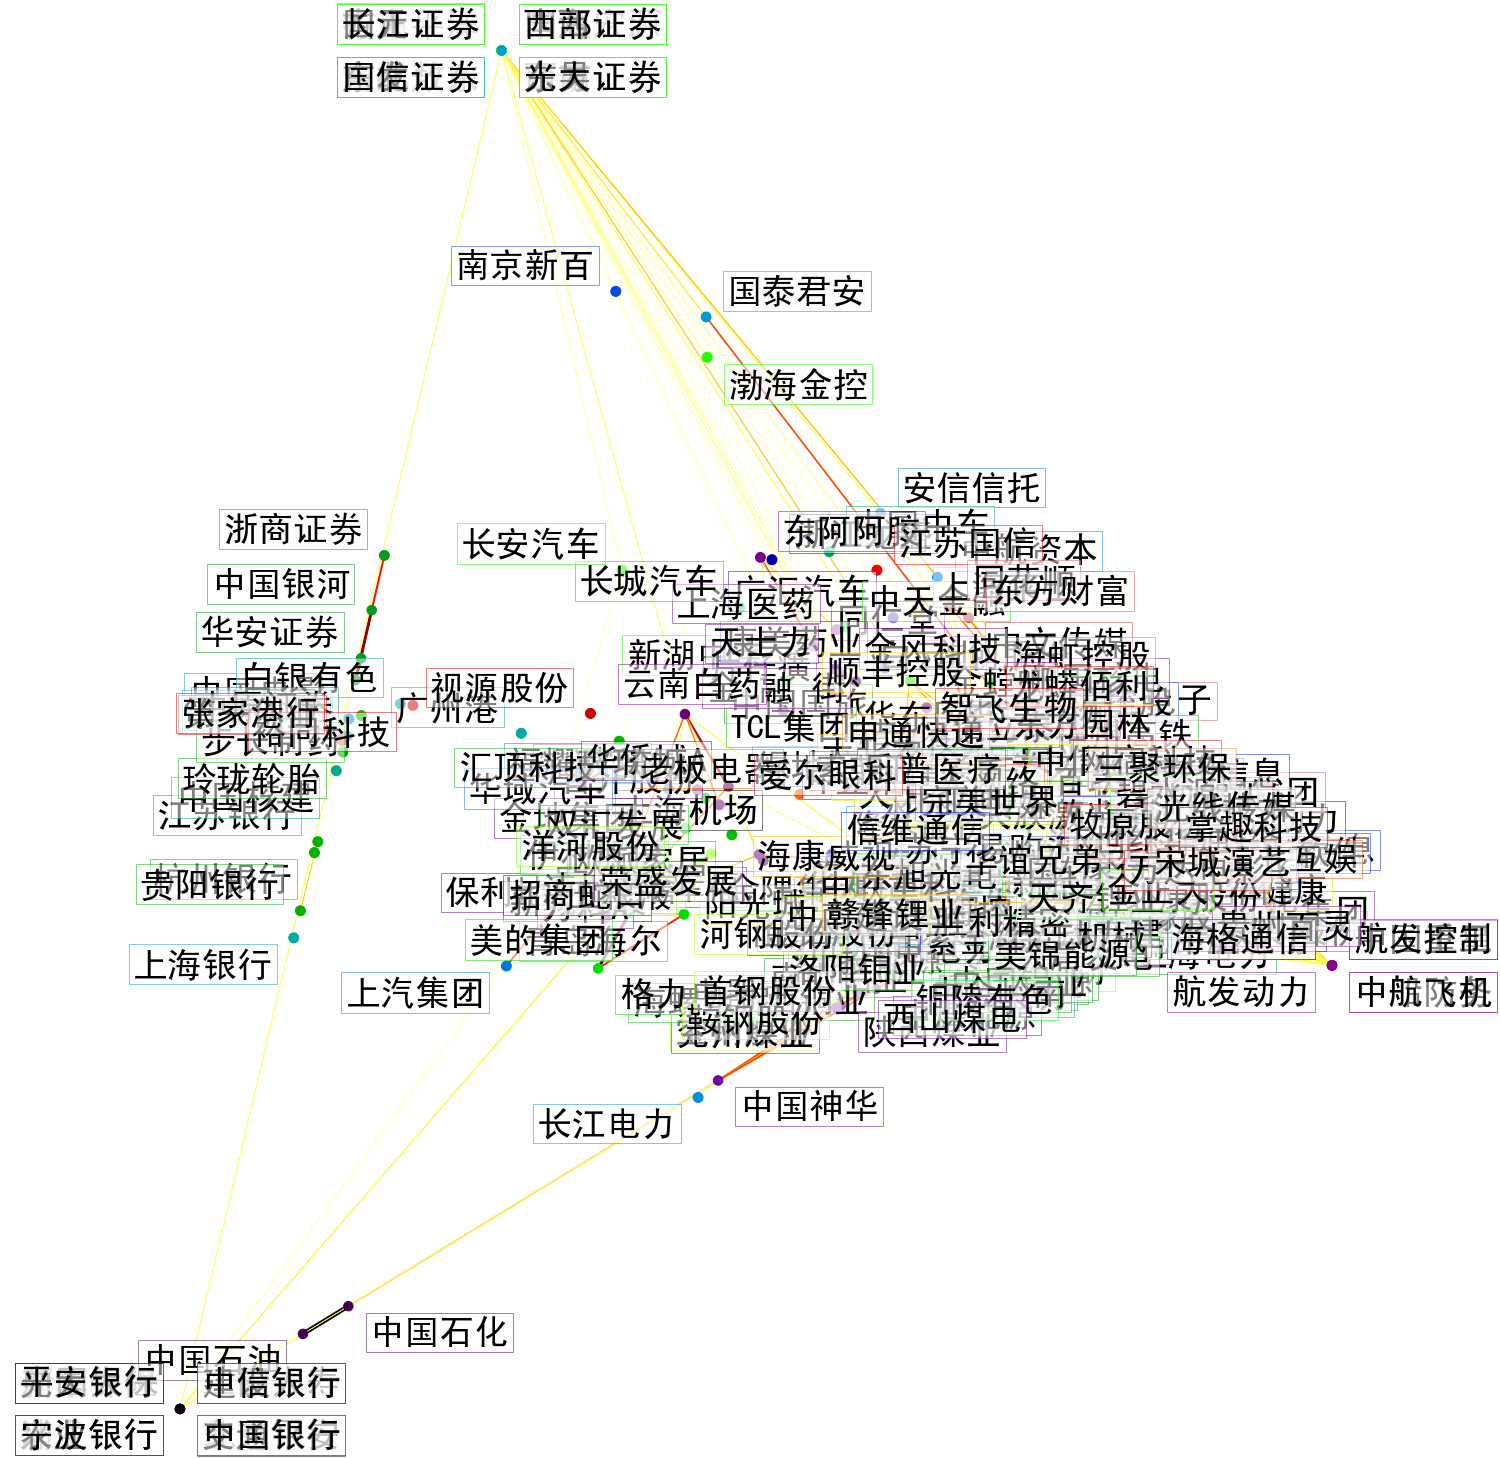

In [61]:
v,a = get_data('2014-1-1','2020-1-1')
clustering_visualized(v,a)